# **MOHD ARHAM SHAIKH**
# **200968051**
# **DL MINI PROJECT- Video Classification: Human Activity Recognition**
# **Dataset-UCF50**

# **Collecting and Storing Data**

In [2]:
#!wget -q --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
#!wget -q --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101TrainTestSplits-RecognitionTask.zip
#!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar

#!unrar x UCF50.rar -inul -y
!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar -inul -y

File ‘UCF50.rar’ already there; not retrieving.



## **IMPORTING LIBRARIES**

In [3]:
import os
import cv2
import math
!pip install pafy
!pip install --upgrade youtube-dl
import pafy
import math


!pip install imageio-ffmpeg

import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:

path_to_data = '/content/UCF50'
classes = os.listdir(path_to_data)
classes[0:10]

['MilitaryParade',
 'Kayaking',
 'Lunges',
 'PoleVault',
 'BaseballPitch',
 'Swing',
 'ThrowDiscus',
 'HorseRiding',
 'HorseRace',
 'Diving']

# **EXPLORATORY DATA ANALYSIS**

# **Visualizing the Data with its Labels**



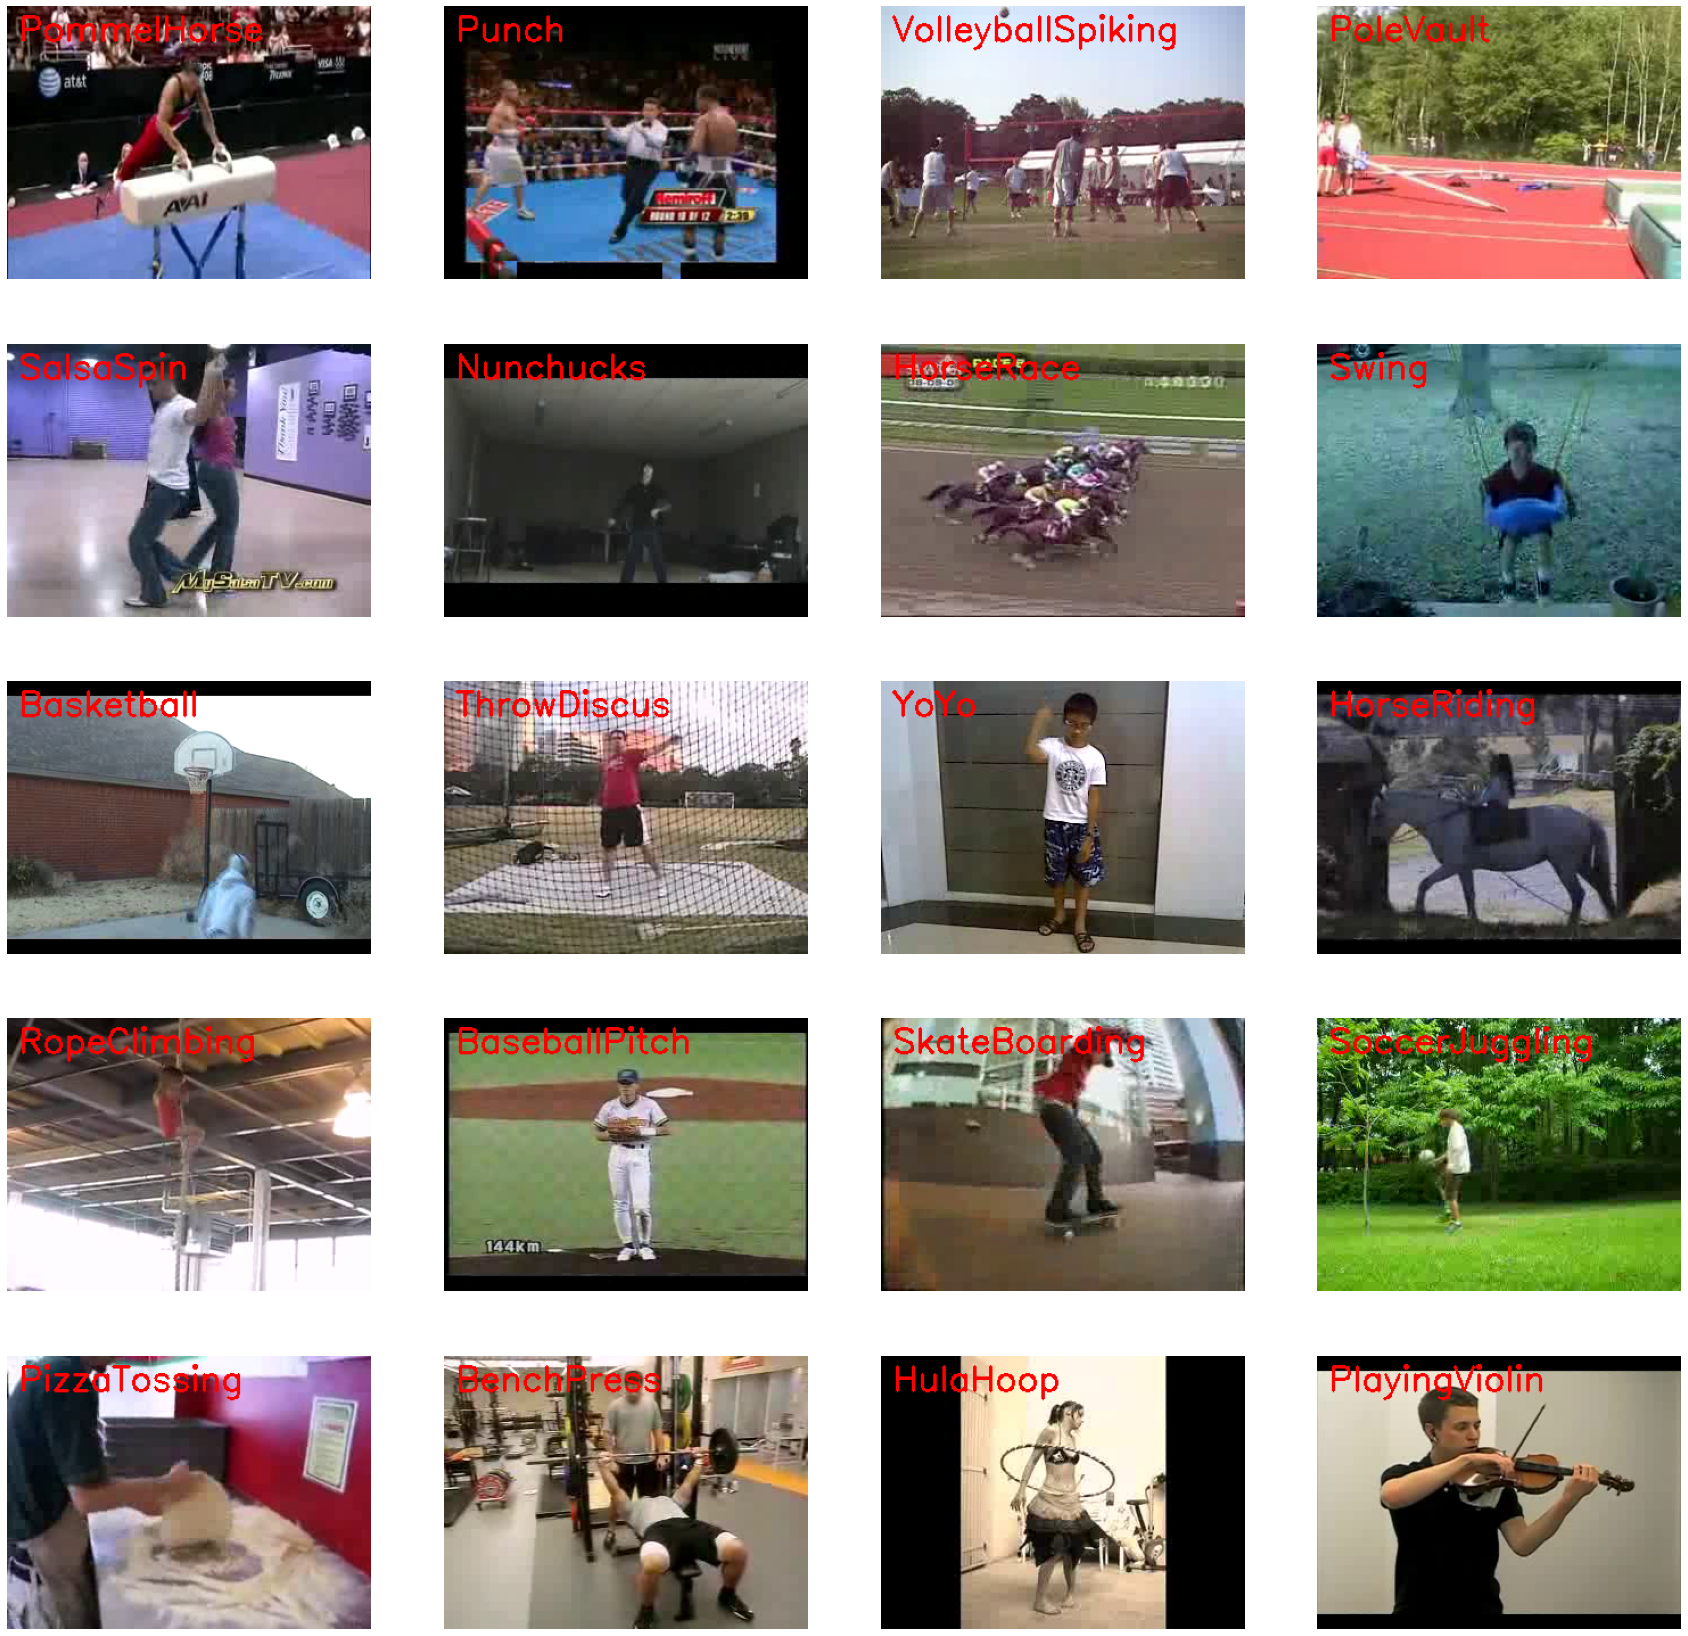

In [4]:
# Create a Matplotlib figure

plt.figure(figsize = (30, 30))

 

# Get Names of all classes in UCF101

all_classes_names = os.listdir('UCF50')
# Generate a random sample of images each time the cell runs

random_range = random.sample(range(len(all_classes_names)), 20)

 

# Iterating through all the random samples

for counter, random_index in enumerate(random_range, 1):

 

    # Getting Class Name using Random Index

    selected_class_Name = all_classes_names[random_index]

 

    # Getting a list of all the video files present in a Class Directory

    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

 

    # Randomly selecting a video file

    selected_video_file_name = random.choice(video_files_names_list)

 

    # Reading the Video File Using the Video Capture

    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

     

    # Reading The First Frame of the Video File

    _, bgr_frame = video_reader.read()

 

    # Closing the VideoCapture object and releasing all resources.

    video_reader.release()

 

    # Converting the BGR Frame to RGB Frame

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

 

    # Adding The Class Name Text on top of the Video Frame.

    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

     

    # Assigning the Frame to a specific position of a subplot

    plt.subplot(5, 4, counter)

    plt.imshow(rgb_frame)

    plt.axis('off')

 




# **Histogram representing number of examples in each class**

In [5]:
number_examples = dict()
for category in classes:
    number_examples[category] = len(os.listdir(path_to_data + '/' + category)) 

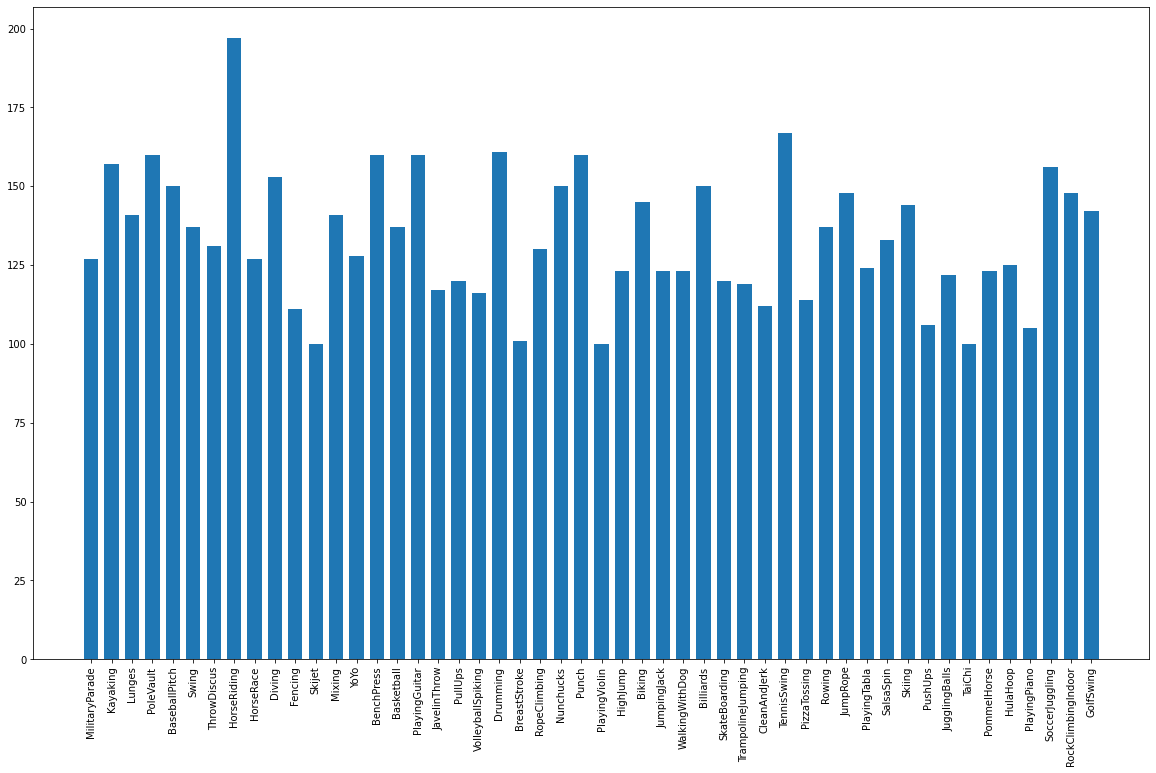

In [6]:
values = list()
keys = list()
for key in number_examples.keys():
    keys.append(key)
    values.append(number_examples[key])
plt.figure(figsize=(20, 12))
plt.bar(range(len(values)), values, width=0.7)
plt.xticks(range(len(keys)), keys, rotation=90)
plt.show()

# **Average number of examples for each class**

In [7]:
print(sum(values) / len(values))


133.62


# **Miminum and Maximum number of examples for any class**

In [8]:
print(min(values), max(values))


100 197


# **Number of frames for each video in each classs**


In [9]:
!pip install imageio-ffmpeg
import imageio
number_of_frames = dict()
for category in classes:
    examples = os.listdir(path_to_data + '/' + category)
    frames = list()
    for example in examples:
        path = os.path.join((path_to_data + '/' + category), example) 
        video = imageio.get_reader(path,  'ffmpeg')
        frames.append(video._meta['nframes'])
    print(category + ' done!')
    number_of_frames[category] = frames

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
MilitaryParade done!
Kayaking done!
Lunges done!
PoleVault done!
BaseballPitch done!
Swing done!
ThrowDiscus done!
HorseRiding done!
HorseRace done!
Diving done!
Fencing done!
Skijet done!
Mixing done!
YoYo done!
BenchPress done!
Basketball done!
PlayingGuitar done!
JavelinThrow done!
PullUps done!
VolleyballSpiking done!
Drumming done!
BreastStroke done!
RopeClimbing done!
Nunchucks done!
Punch done!
PlayingViolin done!
HighJump done!
Biking done!
JumpingJack done!
WalkingWithDog done!
Billiards done!
SkateBoarding done!
TrampolineJumping done!
CleanAndJerk done!
TennisSwing done!
PizzaTossing done!
Rowing done!
JumpRope done!
PlayingTabla done!
SalsaSpin done!
Skiing done!
PushUps done!
JugglingBalls done!
TaiChi done!
PommelHorse done!
HulaHoop done!
PlayingPiano done!
SoccerJuggling done!
RockClimbingIndoor done!
GolfSwing done!


# **PREPROCESSING**

# **Extract, Resize and Normalize Frames**

In [10]:
image_height, image_width = 64, 64

max_images_per_class = 8000

 

dataset_directory = "UCF50"

classes_list = ["YoYo","JumpRope","Skiing","PushUps"]

 

model_output_size = len(classes_list)


In [11]:
def frames_extraction(video_path):

    # Empty List declared to store video frames

    frames_list = []

     

    # Reading the Video File Using the VideoCapture

    video_reader = cv2.VideoCapture(video_path)

 

    # Iterating through Video Frames

    while True:

 

        # Reading a frame from the video file

        success, frame = video_reader.read()

 

        # If Video frame was not successfully read then break the loop

        if not success:

            break

 

        # Resize the Frame to fixed Dimensions

        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        #Gray scaling

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # applying different thresholding techniques(way of partitioning an image into a foreground and background)on the input imageall pixels value above 120 will be set to 255

        ret, thresh1 = cv2.threshold(frame, 120, 255, cv2.THRESH_BINARY)
        #ret, thresh2 = cv2.threshold(frame, 120, 255, cv2.THRESH_BINARY_INV)
        #ret, thresh3 = cv2.threshold(frame, 120, 255, cv2.THRESH_TRUNC)
        #ret, thresh4 = cv2.threshold(frame, 120, 255, cv2.THRESH_TOZERO)
        #ret, thresh5 = cv2.threshold(frame, 120, 255, cv2.THRESH_TOZERO_INV)


         

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1

        normalized_frame = resized_frame / 255

         

        # Appending the normalized frame into the frames list

        frames_list.append(normalized_frame)

     

    # Closing the VideoCapture object and releasing all resources.

    video_reader.release()

 

    # returning the frames list

    return frames_list


In [12]:
def create_dataset():

 

    # Declaring Empty Lists to store the features and labels values.

    temp_features = []

    features = []

    labels = []

     

    # Iterating through all the classes mentioned in the classes list

    for class_index, class_name in enumerate(classes_list):

        print(f'Extracting Data of Class: {class_name}')

         

        # Getting the list of video files present in the specific class name directory

        files_list = os.listdir(os.path.join(dataset_directory, class_name))

 

        # Iterating through all the files present in the files list

        for file_name in files_list:

 

            # Construct the complete video path

            video_file_path = os.path.join(dataset_directory, class_name, file_name)

 

            # Calling the frame_extraction method for every video file path

            frames = frames_extraction(video_file_path)

 

            # Appending the frames to a temporary list.

            temp_features.extend(frames)

         

        # Adding randomly selected frames to the features list

        features.extend(random.sample(temp_features, max_images_per_class))

 

        # Adding Fixed number of labels to the labels list

        labels.extend([class_index] * max_images_per_class)

         

        # Emptying the temp_features list so it can be reused to store all frames of the next class.

        temp_features.clear()

 

    # Converting the features and labels lists to numpy arrays

    features = np.asarray(features)

    labels = np.array(labels) 

 

    return features, labels


In [13]:
features, labels = create_dataset()


Extracting Data of Class: YoYo
Extracting Data of Class: JumpRope
Extracting Data of Class: Skiing
Extracting Data of Class: PushUps


In [14]:
#from tensorflow.keras import utils as np_utils
from keras.utils import to_categorical

In [15]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors

one_hot_encoded_labels = to_categorical(labels)

# **Split the Data into Train and Test Sets**

In [18]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [17]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)


# **Constructing the Model**

In [18]:
# Let's create a function that will construct our model
def create_model():
 
    # We will use a Sequential model for model construction
    model = Sequential()
 
    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))
 
    # Printing the models summary
    model.summary()
 
    return model
 
 
# Calling the create_model method
model = create_model()
 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

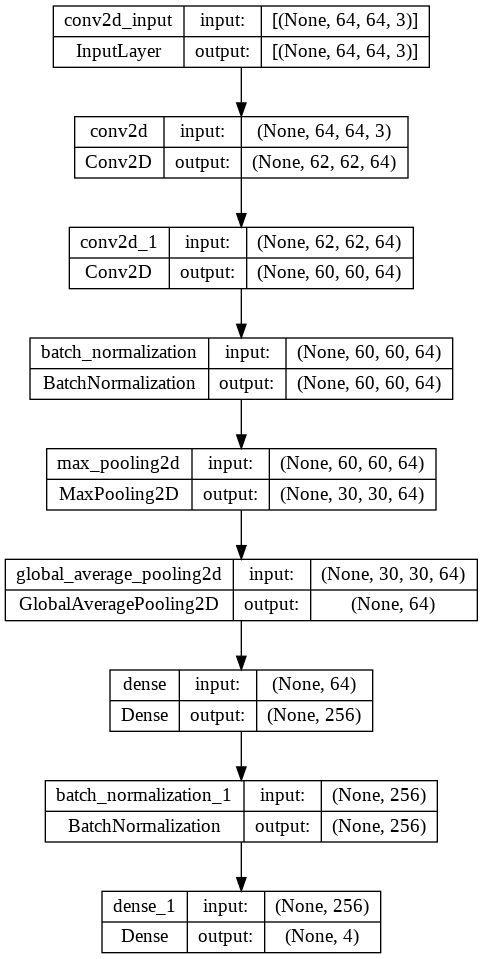

In [19]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)


In [20]:

# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 20, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/20
5120/5120 [==============================] - 33s 4ms/step - loss: 0.7800 - accuracy: 0.6937 - val_loss: 0.3902 - val_accuracy: 0.8578
Epoch 2/20
5120/5120 [==============================] - 22s 4ms/step - loss: 0.3585 - accuracy: 0.8763 - val_loss: 0.2769 - val_accuracy: 0.8854
Epoch 3/20
5120/5120 [==============================] - 24s 5ms/step - loss: 0.2362 - accuracy: 0.9229 - val_loss: 0.0707 - val_accuracy: 0.9828
Epoch 4/20
5120/5120 [==============================] - 22s 4ms/step - loss: 0.1806 - accuracy: 0.9433 - val_loss: 0.0448 - val_accuracy: 0.9797
Epoch 5/20
5120/5120 [==============================] - 25s 5ms/step - loss: 0.1586 - accuracy: 0.9514 - val_loss: 0.4115 - val_accuracy: 0.9232
Epoch 6/20
5120/5120 [==============================] - 25s 5ms/step - loss: 0.1383 - accuracy: 0.9569 - val_loss: 0.0260 - val_accuracy: 0.9924
Epoch 7/20
5120/5120 [==============================] - 23s 4ms/step - loss: 0.1420 - accuracy: 0.9562 - val_loss: 0.0997 - val_ac

In [21]:
model_evaluation_history = model.evaluate(features_test, labels_test)


200/200 [==============================] - 1s 6ms/step - loss: 0.0074 - accuracy: 0.9986


In [22]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___LOSS_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Saving your Model
model.save(model_name)

# **Plot Model’s Loss and Accuracy Curves**

In [23]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]
 
  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
   
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
   
  # Adding title to the plot
  plt.title(str(plot_name))
 
  # Adding legend to the plot
  plt.legend()

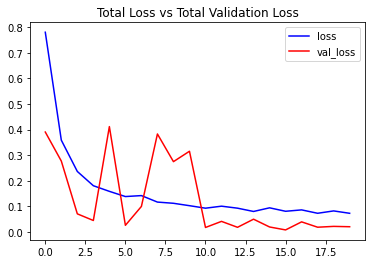

In [24]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')


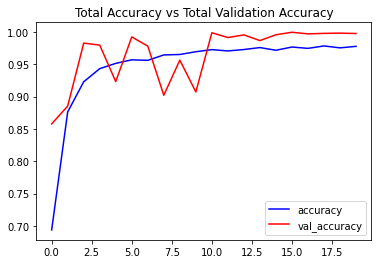

In [25]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')


# **ConvLSTM2D Model**

In [5]:
!pip install pafy youtube-dl moviepy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


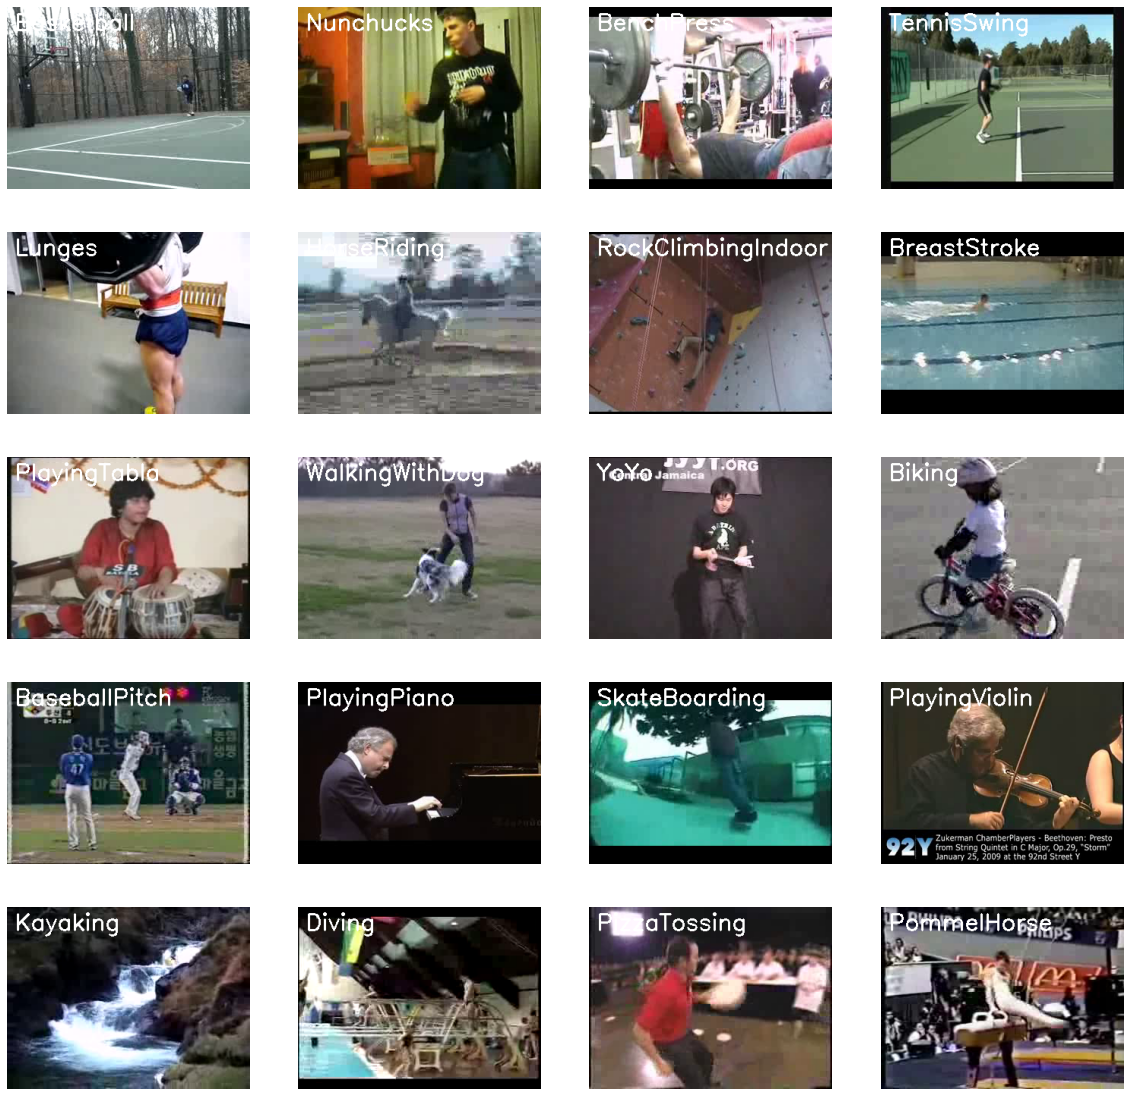

In [6]:

# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))
 
# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')
 
# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 20)
 
# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
 
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
 
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')
 
    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()
 
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [7]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20
 
# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "UCF50"
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["YoYo", "JumpRope", "Skiing", "PushUps"]

In [8]:

def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
 
    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Return the frames list.
    return frames_list

In [9]:

def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
 
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [10]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: YoYo
Extracting Data of Class: JumpRope
Extracting Data of Class: Skiing
Extracting Data of Class: PushUps


In [11]:
one_hot_encoded_labels = to_categorical(labels)

In [19]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

In [13]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''
 
    # We will use a Sequential model for model construction
    model = Sequential()
 
    # Define the Model Architecture.
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [14]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()
 
# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

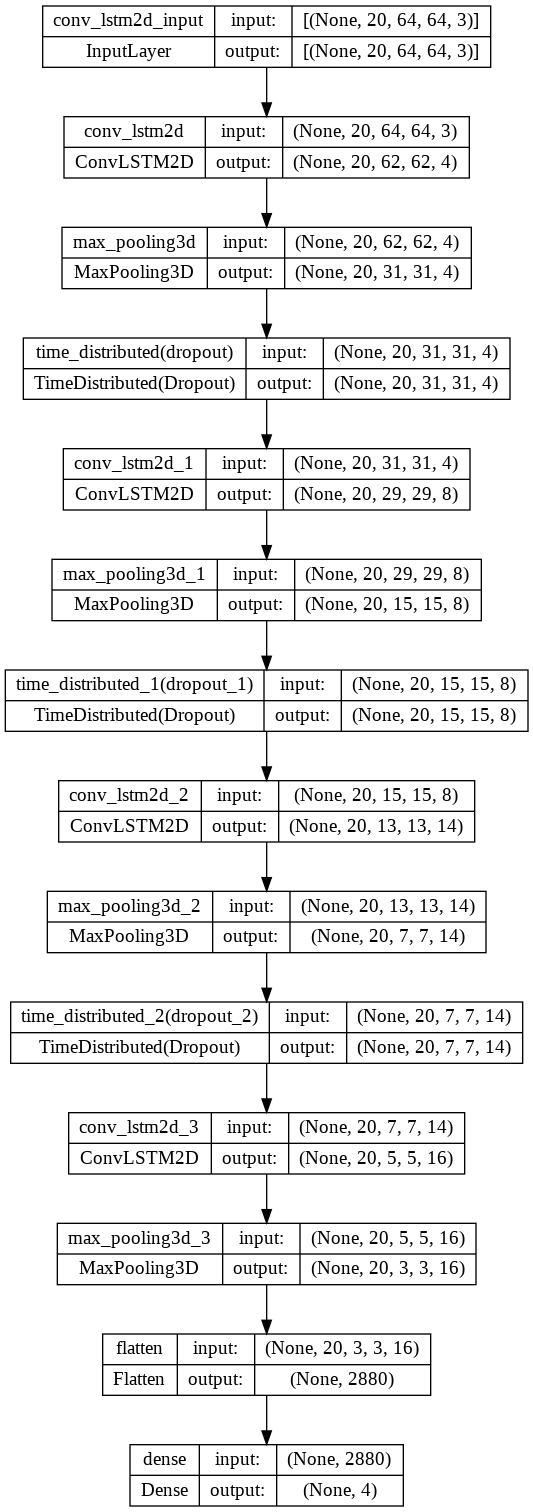

In [15]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

# **Compile & Train the Model**

In [20]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
79/79 [==============================] - 63s 543ms/step - loss: 1.3035 - accuracy: 0.4095 - val_loss: 0.9660 - val_accuracy: 0.5823
Epoch 2/50
79/79 [==============================] - 42s 536ms/step - loss: 0.8509 - accuracy: 0.6698 - val_loss: 0.8432 - val_accuracy: 0.7089
Epoch 3/50
79/79 [==============================] - 44s 551ms/step - loss: 0.5770 - accuracy: 0.7810 - val_loss: 0.7564 - val_accuracy: 0.6835
Epoch 4/50
79/79 [==============================] - 42s 531ms/step - loss: 0.3996 - accuracy: 0.8698 - val_loss: 0.7407 - val_accuracy: 0.7722
Epoch 5/50
79/79 [==============================] - 42s 531ms/step - loss: 0.3188 - accuracy: 0.8762 - val_loss: 0.5687 - val_accuracy: 0.7975
Epoch 6/50
79/79 [==============================] - 42s 534ms/step - loss: 0.2053 - accuracy: 0.9397 - val_loss: 0.4133 - val_accuracy: 0.8228
Epoch 7/50
79/79 [==============================] - 43s 550ms/step - loss: 0.2141 - accuracy: 0.9143 - val_loss: 0.4257 - val_accuracy: 0.8987

# **Evaluate the Model**

In [21]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

5/5 [==============================] - 1s 73ms/step - loss: 0.3198 - accuracy: 0.9242


# **Save the Model**

In [22]:

# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
 
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Save your Model.
convlstm_model.save(model_file_name)

# **Plot Model’s Loss & Accuracy Curves**

In [23]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 
    # Add title to the plot.
    plt.title(str(plot_name))
 
    # Add legend to the plot.
    plt.legend()

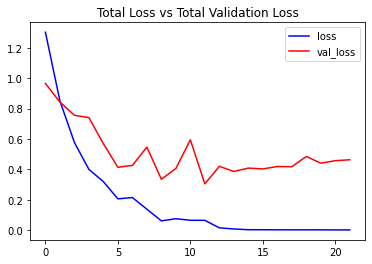

In [24]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

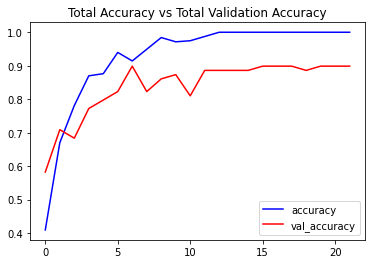

In [25]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# **LRCN( Long-term Recurrent Convolutional Network) Model**

In [26]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''
 
    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
 
 
    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [27]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()
 
# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 20, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 4, 4, 32)    

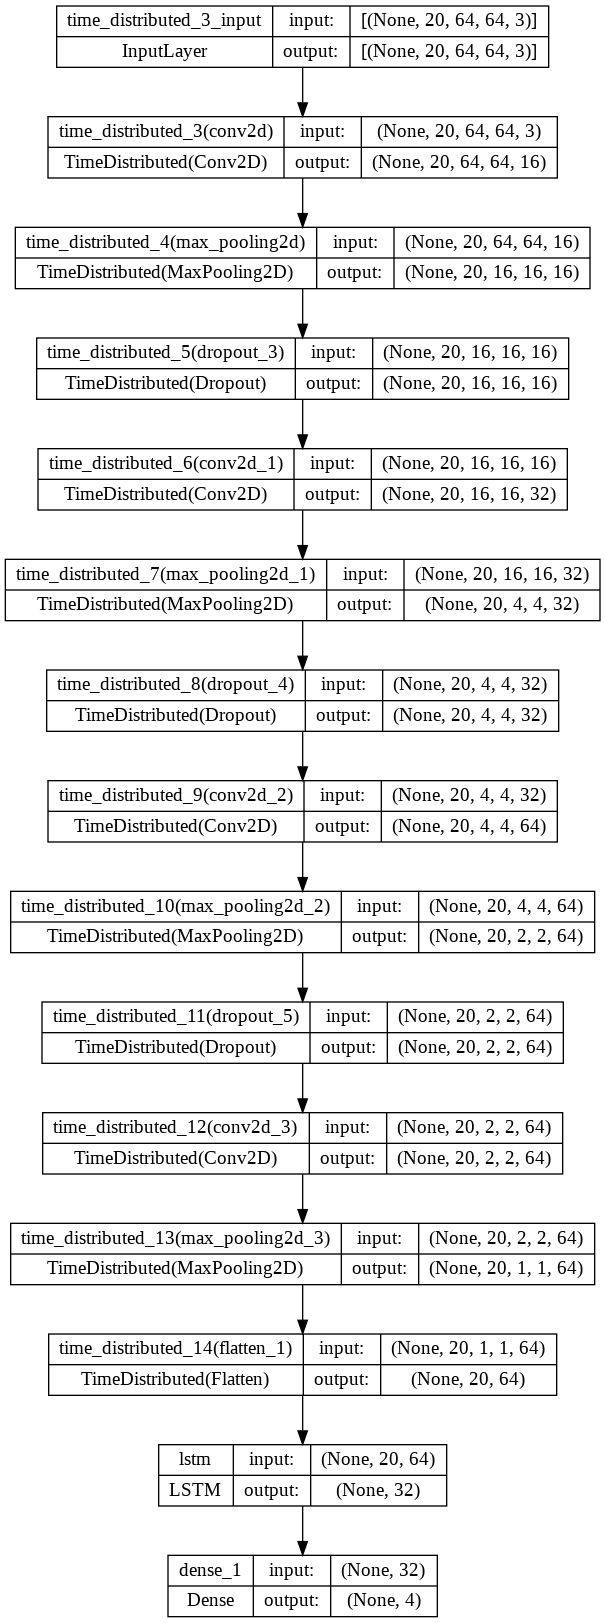

In [28]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

# **Compile and Train the model**

In [29]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
79/79 [==============================] - 5s 20ms/step - loss: 1.3030 - accuracy: 0.3841 - val_loss: 1.1295 - val_accuracy: 0.3924
Epoch 2/70
79/79 [==============================] - 1s 10ms/step - loss: 1.1390 - accuracy: 0.4540 - val_loss: 1.0900 - val_accuracy: 0.4937
Epoch 3/70
79/79 [==============================] - 1s 11ms/step - loss: 0.9197 - accuracy: 0.5619 - val_loss: 1.1196 - val_accuracy: 0.5063
Epoch 4/70
79/79 [==============================] - 1s 10ms/step - loss: 0.7895 - accuracy: 0.6667 - val_loss: 0.7189 - val_accuracy: 0.7215
Epoch 5/70
79/79 [==============================] - 1s 10ms/step - loss: 0.7282 - accuracy: 0.7206 - val_loss: 0.7518 - val_accuracy: 0.6835
Epoch 6/70
79/79 [==============================] - 1s 11ms/step - loss: 0.6083 - accuracy: 0.7556 - val_loss: 0.6967 - val_accuracy: 0.7089
Epoch 7/70
79/79 [==============================] - 1s 10ms/step - loss: 0.6503 - accuracy: 0.7556 - val_loss: 0.6195 - val_accuracy: 0.7848
Epoch 8/70
79

# **Evaluate the model**

In [30]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

5/5 [==============================] - 0s 20ms/step - loss: 0.3220 - accuracy: 0.9167


# **Save the Model**

In [31]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Save the Model.
LRCN_model.save(model_file_name)

# **Plot Model’s Loss & Accuracy Curves**

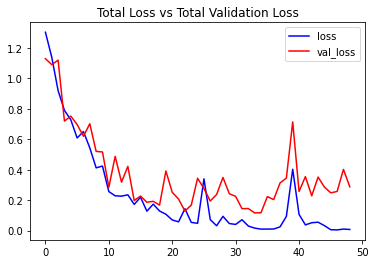

In [32]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

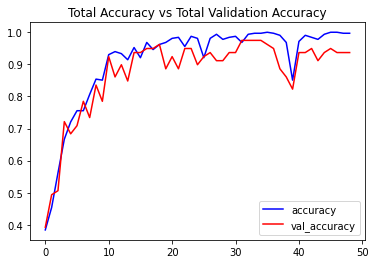

In [33]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')


# Simple CNN- loss: 0.0074 - accuracy: 0.9986



# **ConvLSTM- loss: 0.3198 - accuracy: 0.9242**

# LRCN- loss: 0.3220 - accuracy: 0.9167

## Thus by comparing the above loss and accuracy of the 3 models we can conclude that simple CNN model works the best for UCF50 dataset